In [1]:
import pyodbc
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
from scipy.stats import ttest_rel
import calendar
import warnings
from scipy import stats
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
import pickle
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import seaborn as sns
warnings.filterwarnings('ignore')
# Configure inline mode
%matplotlib inline

# from dataprep.eda import *
pd.set_option('display.max_columns', None)


/home/yang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
# df_processed_final.to_csv('df_processed_final.csv',index = False)
df_processed_final = pd.read_csv('df_processed_final.csv',index_col=None)

In [3]:
x_clean_z_score = df_processed_final[['Gator', 'Longitudinal_wp', 'Longitudinal_nwp', 'Patch_area',
       'Patch_number', 'Wp_length', 'Transverse_length_gt183', 'Rutting',
       'Friction', 'Initial_IRI', 'Bc_asphalt_layer_modulus',
       'Bc_friction_layer_modulus', 'Hydraulic_conductivity', 'Mon_precip_avg',
       'Freeze_index_avg', 'Kesal', 'Kesal_exp_2', 'Age',
       'Asphalt_specific_gravity', 'Aggregate_comp_percent']]
y_clean_z_score = df_processed_final["IRI"]

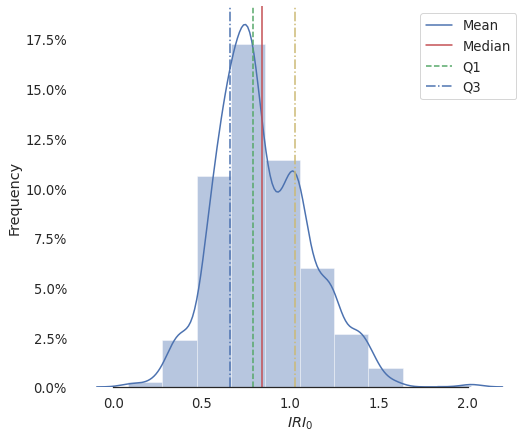

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(x_clean_z_score['Initial_IRI'], color="b",bins=10)
ax.yaxis.set_major_formatter(PercentFormatter(10))
sns.despine(trim=True, left=True)

ax.set(xlabel='${IRI_0}$', ylabel='Frequency')


# ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12)



mean=x_clean_z_score['Initial_IRI'].mean()  #0.8394
median=x_clean_z_score['Initial_IRI'].median() #0.7882
q1 = np.quantile(x_clean_z_score['Initial_IRI'], .25) #0.66127
q3 = np.quantile(x_clean_z_score['Initial_IRI'], .75) #1.025352

ax.axvline(mean, color='r', linestyle='-')
ax.axvline(median, color='g', linestyle='--')
ax.axvline(q1, color='b', linestyle='-.')
ax.axvline(q3, color='y', linestyle='-.')


plt.legend({'Mean':mean,'Median':median,'Q1':q1,'Q3':q3})

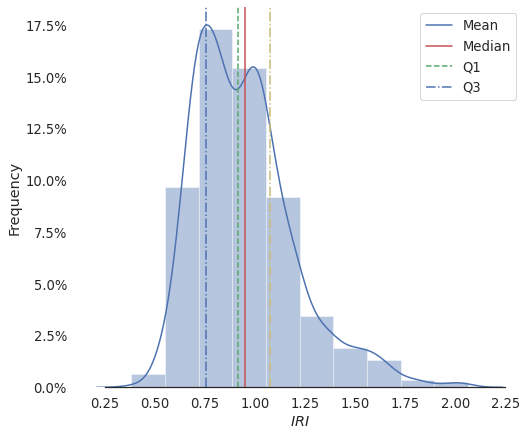

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(y_clean_z_score, color="b",bins=10)
ax.yaxis.set_major_formatter(PercentFormatter(10))
sns.despine(trim=True, left=True)

ax.set(xlabel='${IRI}$', ylabel='Frequency')


mean=y_clean_z_score.mean()  #0.8394
median=y_clean_z_score.median() #0.7882
q1 = np.quantile(y_clean_z_score, .25) #0.66127
q3 = np.quantile(y_clean_z_score, .75) #1.025352

ax.axvline(mean, color='r', linestyle='-')
ax.axvline(median, color='g', linestyle='--')
ax.axvline(q1, color='b', linestyle='-.')
ax.axvline(q3, color='y', linestyle='-.')


plt.legend({'Mean':mean,'Median':median,'Q1':q1,'Q3':q3})

In [6]:
X_train_clean_z_score, X_test_clean_z_score, y_train_clean_z_score, y_test_clean_z_score = train_test_split( x_clean_z_score, y_clean_z_score, test_size=0.2, random_state=42)

## Parameter tuning

In [18]:
params = {
          'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'l1',
          'nthread':16,
          'learning_rate':0.1,
          'num_leaves':128, 
          'max_depth': 8,   
          'subsample': 0.8, 
          'colsample_bytree': 0.8,
          "verbose": -1
    }
    
data_train = lgb.Dataset(X_train_clean_z_score, y_train_clean_z_score)
cv_results = lgb.cv(params, data_train, num_boost_round=100000, nfold=5, stratified=False, shuffle=True,early_stopping_rounds=1000,seed=0)
print('best n_estimators:', len(cv_results['l1-mean']))
print('best cv score:', pd.Series(cv_results['l1-mean']).min())



best n_estimators: 1544
best cv score: 0.06177286228149874


In [25]:
from sklearn.model_selection import GridSearchCV

params_test0={'n_estimators': range(100,3001,100), 'learning_rate':[0.05, 0.1,0.2, 0.3]} # 7*15=105 candidates 
              
gsearch0 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       max_depth=8, 
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                        param_grid = params_test0, 
                        scoring='neg_mean_absolute_error',
                        cv=5,  #105*5=525 fits
                        n_jobs=-1,  #use all cores
                        verbose=10, #the greater the number the more detail you will get
                        return_train_score = True)  

gsearch0.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch0.cv_results_, 
gsearch0.best_params_, gsearch0.best_score_  #  


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1982s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (3.6596s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:   15.6s
[Parallel(n_

({'learning_rate': 0.05, 'n_estimators': 2500}, -0.06215685634083655)

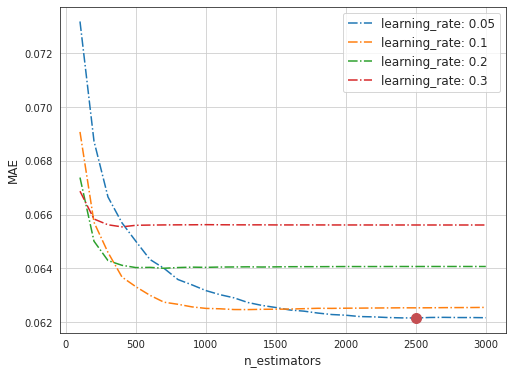

In [37]:
def plot_grid_search(grid, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = -grid.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = grid.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(8, 6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-.', label= name_param_2 + ': ' + str(val))
    plt.plot(grid.best_params_[name_param_1],-grid.best_score_,'ro',markersize=10) 

    # ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid('on')

# Calling Method 
n_estimators = range(100,3001,100)
learning_rate = [0.05, 0.1,0.2, 0.3]
plot_grid_search(gsearch0, n_estimators, learning_rate, 'n_estimators', 'learning_rate')

In [39]:
params_test1={'max_depth': range(3,12,2), 'num_leaves':range(5, 150, 10)} # 7*15=105 candidates 
              
gsearch1 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch0.best_params_['learning_rate'], 
                                                       n_estimators=gsearch0.best_params_['n_estimators'], 
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                        param_grid = params_test1, 
                        scoring='neg_mean_absolute_error',
                        cv=5,  #105*5=525 fits
                        n_jobs=-1,  #use all cores
                        verbose=10)  #the greater the number the more detail you will get

gsearch1.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_  #  


Fitting 5 folds for each of 75 candidates, totalling 375 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  

({'max_depth': 9, 'num_leaves': 35}, -0.06142631674636301)

In [42]:
params_test2={'max_bin': range(5,600,20), 'min_data_in_leaf':range(0,52,10)}
              
gsearch2 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch0.best_params_['learning_rate'], 
                                                       n_estimators=gsearch0.best_params_['n_estimators'], 
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       bagging_fraction = 0.8,
                                                       feature_fraction = 0.8), 
                        param_grid = params_test2,
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)

gsearch2.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 

({'max_bin': 265, 'min_data_in_leaf': 0}, -0.05846307258812785)

In [43]:
params_test3={'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,51,10)
}
              
gsearch3 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch0.best_params_['learning_rate'], 
                                                       n_estimators=gsearch0.best_params_['n_estimators'],
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf']), 
                        param_grid = params_test3, 
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)
gsearch3.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 

({'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.8},
 -0.05846307258812785)

In [44]:
params_test4={'lambda_l1': [0, 1e-4,1e-2,1e-1,0.3,0.5,0.7,0.9,1.0],
              'lambda_l2': [0, 1e-4,1e-2,1e-1,0.3,0.5,0.7,0.9,1.0]
}
              
gsearch4 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch0.best_params_['learning_rate'], 
                                                       n_estimators=gsearch0.best_params_['n_estimators'],
                                                       max_depth=gsearch1.best_params_['max_depth'], 
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'], 
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction']), 
                        param_grid = params_test4, 
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)

gsearch4.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch4.best_params_, 
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  

({'lambda_l1': 0.01, 'lambda_l2': 0.01}, -0.058036903698782685)

In [45]:
params_test5={'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
              
gsearch5 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch0.best_params_['learning_rate'], 
                                                       n_estimators=gsearch0.best_params_['n_estimators'], 
                                                       max_depth=gsearch1.best_params_['max_depth'],  
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'], 
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction'],
                                                       lambda_l1=gsearch4.best_params_['lambda_l1'],
                                                       lambda_l2=gsearch4.best_params_['lambda_l2']), 
                        param_grid = params_test5, 
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)

gsearch5.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch5.best_params_, 
gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  55 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  55 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  26 out of  55 | elapsed:    0.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  38 out of  55 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  44 out of  55 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  55 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    3.0s finished


({'min_split_gain': 0.0}, -0.058036903698782685)

In [47]:
params_test6={'n_estimators': range(50,10001,50), 'learning_rate':[0.01, 0.015,0.025, 0.05,0.1]}
              
gsearch6 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       max_depth=gsearch1.best_params_['max_depth'],  
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'], 
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction'],
                                                       lambda_l1=gsearch4.best_params_['lambda_l1'],
                                                       lambda_l2=gsearch4.best_params_['lambda_l2'], 
                                                       min_split_gain = gsearch5.best_params_['min_split_gain']),
                        param_grid = params_test6, 
                        scoring='neg_mean_absolute_error',
                        cv=5,
                        n_jobs=-1,
                        verbose=10)

gsearch6.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch6.best_params_, 
gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed

({'learning_rate': 0.015, 'n_estimators': 3400}, -0.0577799372510733)

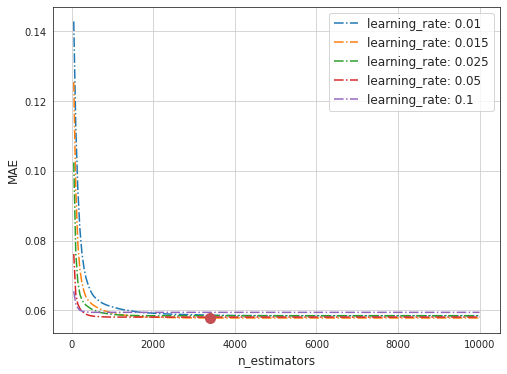

In [48]:
# Calling Method 
n_estimators =  range(50,10001,50)
learning_rate = [0.01, 0.015,0.025, 0.05,0.1]
plot_grid_search(gsearch6, n_estimators, learning_rate, 'n_estimators', 'learning_rate')

In [ ]:
import sklearn.metrics as metrics

model=lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         metrics='l1',
                         learning_rate=gsearch6.best_params_['learning_rate'], 
                         n_estimators=10000,
                        #  n_estimators=gsearch6.best_params_['n_estimators'], 
                         max_depth=gsearch1.best_params_['max_depth'],
                         num_leaves=gsearch1.best_params_['num_leaves'],
                         max_bin=gsearch2.best_params_['max_bin'],
                         min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'],
                         bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                         bagging_freq= gsearch3.best_params_['bagging_freq'], 
                         feature_fraction= gsearch3.best_params_['feature_fraction'],
                         lambda_l1=gsearch4.best_params_['lambda_l1'],
                         lambda_l2=gsearch4.best_params_['lambda_l2'], 
                         min_split_gain=gsearch5.best_params_['min_split_gain'])

model.fit(X_train_clean_z_score,
y_train_clean_z_score,
eval_set=[(X_test_clean_z_score, y_test_clean_z_score)],
eval_metric='l1',
early_stopping_rounds=1000,
verbose=False)

y_pre_train = model.predict(X_train_clean_z_score)
y_pre_test=model.predict(X_test_clean_z_score)
print("Mean Absolute Error : " + str(mean_absolute_error(y_pre_test, y_test_clean_z_score)))
print("rsquare:",metrics.explained_variance_score(y_test_clean_z_score, y_pre_test))
print("mae:",metrics.mean_absolute_error(y_test_clean_z_score, y_pre_test))
print("mse:",metrics.mean_squared_error(y_test_clean_z_score, y_pre_test))

In [7]:
# len(model.evals_result_['valid_0']['l1'])

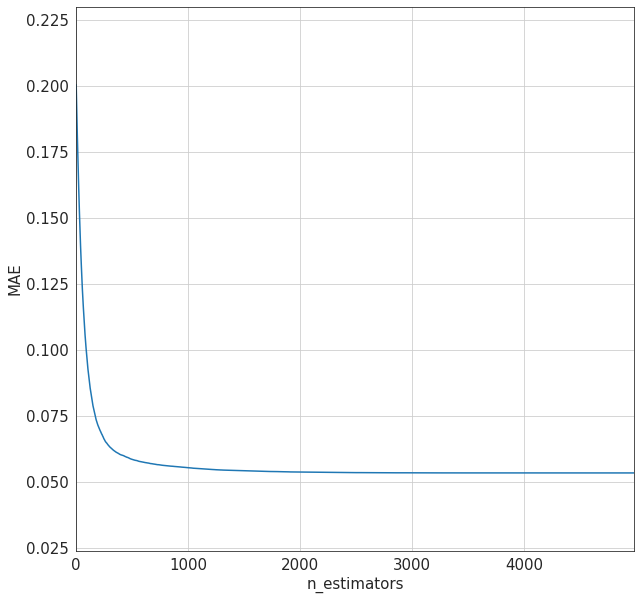

In [25]:

fig = lgb.plot_metric(model, metric='l1',figsize=(10,10))
# fig.plot(model.best_iteration_,model.best_score_['valid_0']['l1'],'ro',markersize=10)
# fig.annotate('('+str(model.best_iteration_)+','+str(round(model.best_score_['valid_0']['l1'],3))+')', xy =(model.best_iteration_,model.best_score_['valid_0']['l1']),xytext =(model.best_iteration_,model.best_score_['valid_0']['l1']+0.01),fontsize=15) 
# fig.text(model.best_iteration_,model.best_score_['valid_0']['l1'],'('+str(model.best_iteration_)+','+str(round(model.best_score_['valid_0']['l1'],3))+')',fontsize=20)
fig.get_figure().gca().set_title("")
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
fig.set_xlabel('n_estimators', fontsize=15)
fig.set_ylabel('MAE', fontsize=15)
fig.get_legend().remove()
plt.savefig('learning curve.png')
plt.show()


## Save & load model

In [22]:
# pickle.dump(model, open("model_all_positive.dat", "wb"))
model = pickle.load(open("model_all_positive.dat", "rb"))
y_pre_train = model.predict(X_train_clean_z_score)
y_pre_test = model.predict(X_test_clean_z_score)

In [25]:
model

LGBMRegressor(bagging_fraction=0.6, bagging_freq=0, feature_fraction=0.8,
              lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.015, max_bin=265,
              max_depth=9, metrics='l1', min_data_in_leaf=0, min_split_gain=0,
              n_estimators=10000, num_leaves=35, objective='regression',
              silent=True)

## Model Result

In [28]:
# r square train
print("r_squared_train:",metrics.explained_variance_score(y_train_clean_z_score, y_pre_train))

# r square test
print("r_squared_test:",metrics.explained_variance_score(y_test_clean_z_score, y_pre_test))


r_squared_train: 0.9999295805458268
r_squared_test: 0.8748335444240722


In [10]:
# mae train
print("mae_train:",metrics.mean_absolute_error(y_train_clean_z_score, y_pre_train))

# mae test
print("mae_test:",metrics.mean_absolute_error(y_test_clean_z_score, y_pre_test))


mae_train: 0.0015511006253218225
mae_test: 0.053382599292538954


In [147]:
# mse train
print("mse_train:",metrics.mean_squared_error(y_train_clean_z_score, y_pre_train))

# mse test
print("mse_test:",metrics.mean_squared_error(y_test_clean_z_score, y_pre_test))

mse_train: 4.471029225956161e-06
mse_test: 0.008705025487037688


In [148]:
# rmse train
print("rmse_train:",metrics.mean_squared_error(y_train_clean_z_score, y_pre_train)**0.5)

# rmse test
print("rmse_test:",metrics.mean_squared_error(y_test_clean_z_score, y_pre_test)**0.5)

rmse_train: 0.0021144808407635575
rmse_test: 0.0933007260799062


In [141]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# rmse train
print("mape_train:",mean_absolute_percentage_error(y_train_clean_z_score, y_pre_train))

# rmse test
print("mape_test:",mean_absolute_percentage_error(y_test_clean_z_score, y_pre_test))

mape_train: 0.16978346266522024
mape_test: 5.41349990126218


## Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

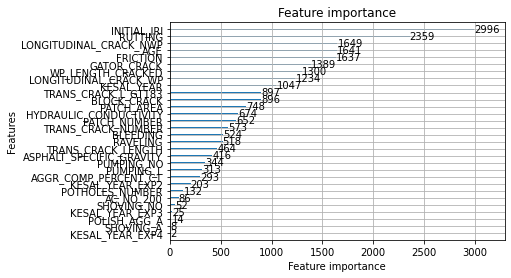

In [9]:
lgb.plot_importance(model, max_num_features = 30, importance_type='split')

In [35]:
importance = pd.DataFrame()
importance['Feature'] = X_train_clean_z_score.columns.values
importance['ImportanceWeight'] = model.feature_importances_ #importance_type = 'split'
# importance['ImportanceGain'] = model.feature_importance(importance_type = 'gain')

importance.sort_values(by = 'ImportanceWeight', ascending = False, inplace = True)
importance.head(10)

Feature  ImportanceWeight
27             INITIAL_IRI              2996
18                 RUTTING              2359
3   LONGITUDINAL_CRACK_NWP              1649
26                     AGE              1641
19                FRICTION              1637
0              GATOR_CRACK              1389
16       WP_LENGTH_CRACKED              1300
2    LONGITUDINAL_CRACK_WP              1234
38              KESAL_YEAR              1047
17     TRANS_CRACK_L_GT183               897

## Residual distribution

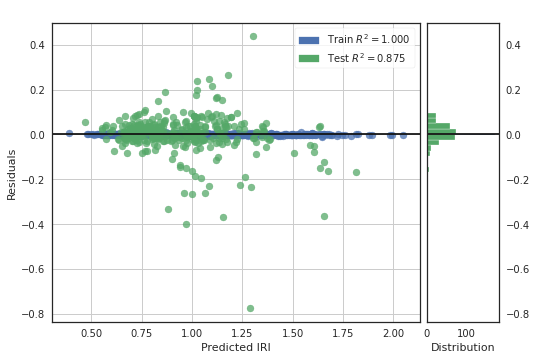

In [349]:

from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model,title=" ", hist=True)
visualizer.fit(X_train_clean_z_score, y_train_clean_z_score) 
visualizer.score(X_test_clean_z_score, y_test_clean_z_score) 


visualizer.finalize()


visualizer.ax.set_xlabel("Predicted IRI")



plt.grid()
plt.savefig("residual distribution.png")

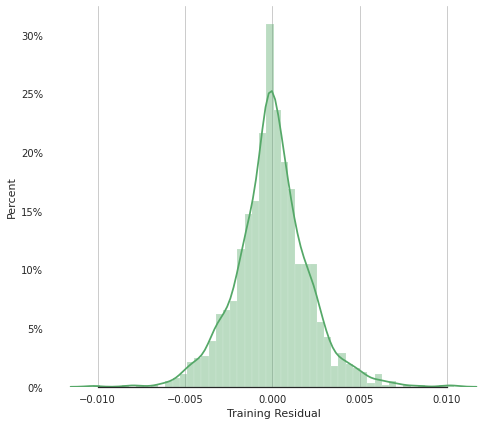

In [366]:
from scipy.stats import norm 
from  matplotlib.ticker import PercentFormatter
nbins = 20
xlen = np.linspace(-0.4,0.4,nbins)
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_pre_train-y_train_clean_z_score, color="g",hist=1, kde=True,norm_hist=1)
ax.xaxis.grid(True)
ax.set(ylabel="Percent")
ax.set(xlabel="Training Residual")
# ax.set(title="SalePrice distribution")
mu, std = norm.fit(y_pre_train-y_train_clean_z_score)
p = np.diff(norm.cdf((xlen-mu)/std))
# ax.plot(xlen[:(len(xlen)-1)]+binwidth/2,p*len(x),color='lightseagreen')
ax.set_yticklabels(ax.get_yticks()/len(y_train_clean_z_score))
ax.yaxis.set_major_formatter(PercentFormatter(1000,decimals=0))
sns.despine(trim=True, left=True)
plt.savefig("train residual histogram.png")
plt.show()

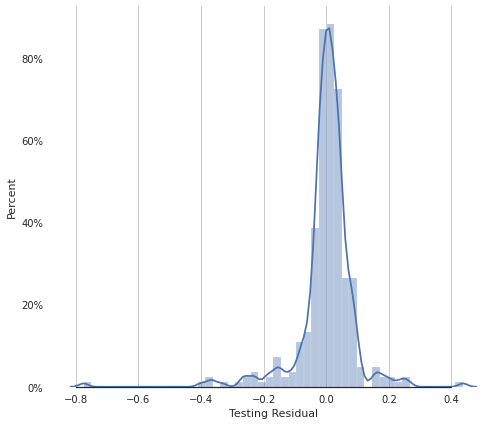

In [355]:
from scipy.stats import norm 
from  matplotlib.ticker import PercentFormatter
nbins = 20
xlen = np.linspace(-0.4,0.4,nbins)
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(y_pre_test-y_test_clean_z_score, color="b",hist=1, kde=True,norm_hist=1)
ax.xaxis.grid(True)
ax.set(ylabel="Percent")
ax.set(xlabel="Testing Residual")
# ax.set(title="SalePrice distribution")
mu, std = norm.fit(y_pre_test-y_test_clean_z_score)
p = np.diff(norm.cdf((xlen-mu)/std))
# ax.plot(xlen[:(len(xlen)-1)]+binwidth/2,p*len(x),color='lightseagreen')
ax.set_yticklabels(ax.get_yticks()/len(y_test_clean_z_score))
ax.yaxis.set_major_formatter(PercentFormatter(10))
sns.despine(trim=True, left=True)
plt.savefig("residual histogram.png")
plt.show()

## Prediction Error Plot

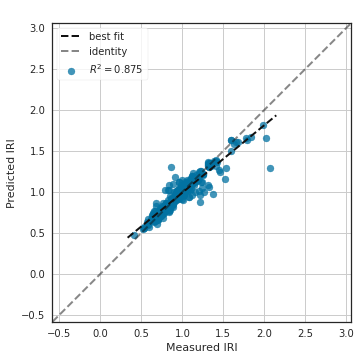

In [295]:

from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

visualizer = PredictionError(model,title=" ")

visualizer.fit(X_train_clean_z_score, y_train_clean_z_score)  # Fit the training data to the visualizer
visualizer.score(X_test_clean_z_score, y_test_clean_z_score)  # Evaluate the model on the test data
visualizer.finalize()


visualizer.ax.set_xlabel("Measured IRI")
visualizer.ax.set_ylabel("Predicted IRI")
plt.grid()
plt.savefig("Prediction Error Plot.png")
# visualizer.show(outpath="Prediction Error Plot.png")
# visualizer.show()                 # Finalize and render the figure

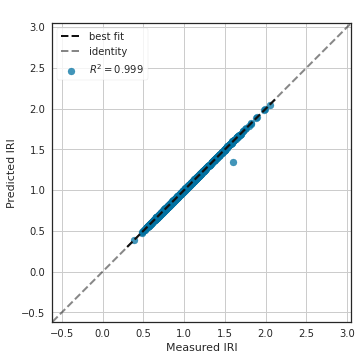

In [298]:

from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

visualizer = PredictionError(model,title=" ")

visualizer.fit(X_train_clean_z_score, y_train_clean_z_score)  # Fit the training data to the visualizer
visualizer.score(X_train_clean_z_score, y_train_clean_z_score)  # Evaluate the model on the test data
visualizer.finalize()


visualizer.ax.set_xlabel("Measured IRI")
visualizer.ax.set_ylabel("Predicted IRI")
plt.grid()
plt.savefig("Prediction Error Plot_train.png")
# visualizer.show(outpath="Prediction Error Plot.png")
# visualizer.show()                 # Finalize and render the figure

## sensitivity analysis

In [383]:


params_test_s1={'n_estimators': range(100,5001,100), 'learning_rate':[0.010,0.015,0.1,0.2,0.3]} # 7*15=105 candidates 
              
gsearch_s1 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       max_depth=gsearch1.best_params_['max_depth'],
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'],
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction'],
                                                       lambda_l1=gsearch4.best_params_['lambda_l1'],
                                                       lambda_l2=gsearch4.best_params_['lambda_l2'], 
                                                       min_split_gain=gsearch5.best_params_['min_split_gain']), 
                        param_grid = params_test_s1, 
                        scoring='neg_mean_absolute_error',
                        cv=5,  #105*5=525 fits
                        n_jobs=-1,  #use all cores
                        verbose=10, #the greater the number the more detail you will get
                        return_train_score = True)  

gsearch_s1.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch_s1.cv_results_, 
gsearch_s1.best_params_, gsearch_s1.best_score_  #  


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:

({'learning_rate': 0.015, 'n_estimators': 3400}, -0.0577799372510733)

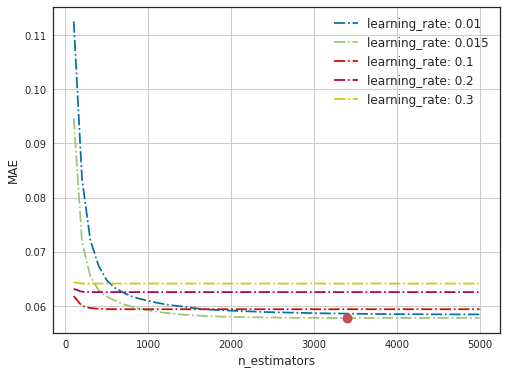

In [385]:
def plot_grid_search(grid, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = -grid.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = grid.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(8, 6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-.', label= name_param_2 + ': ' + str(val))
    plt.plot(grid.best_params_[name_param_1],-grid.best_score_,'ro',markersize=10) 

    # ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid('on')

# Calling Method 
n_estimators = range(100,5001,100)
learning_rate = [0.010,0.015,0.1,0.200,0.300]
plot_grid_search(gsearch_s1, n_estimators, learning_rate, 'n_estimators', 'learning_rate')
plt.savefig("gsearch_s1.png")

In [386]:

params_test_s2={'n_estimators': range(100,5001,100), 'max_depth':[3,5,7,9,11]} # 7*15=105 candidates 
              
gsearch_s2 = GridSearchCV(estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                                       objective='regression',
                                                       metrics='l1',
                                                       learning_rate=gsearch6.best_params_['learning_rate'],
                                                       max_depth=gsearch1.best_params_['max_depth'],
                                                       num_leaves=gsearch1.best_params_['num_leaves'],
                                                       max_bin=gsearch2.best_params_['max_bin'],
                                                       min_data_in_leaf=gsearch2.best_params_['min_data_in_leaf'],
                                                       bagging_fraction=gsearch3.best_params_['bagging_fraction'],
                                                       bagging_freq= gsearch3.best_params_['bagging_freq'], 
                                                       feature_fraction= gsearch3.best_params_['feature_fraction'],
                                                       lambda_l1=gsearch4.best_params_['lambda_l1'],
                                                       lambda_l2=gsearch4.best_params_['lambda_l2'], 
                                                       min_split_gain=gsearch5.best_params_['min_split_gain']), 
                        param_grid = params_test_s2, 
                        scoring='neg_mean_absolute_error',
                        cv=5,  #105*5=525 fits
                        n_jobs=-1,  #use all cores
                        verbose=10, #the greater the number the more detail you will get
                        return_train_score = True)  

gsearch_s2.fit(X_train_clean_z_score,y_train_clean_z_score)
# gsearch_s2.cv_results_, 
gsearch_s2.best_params_, gsearch_s2.best_score_  #  


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:

({'max_depth': 9, 'n_estimators': 3400}, -0.0577799372510733)

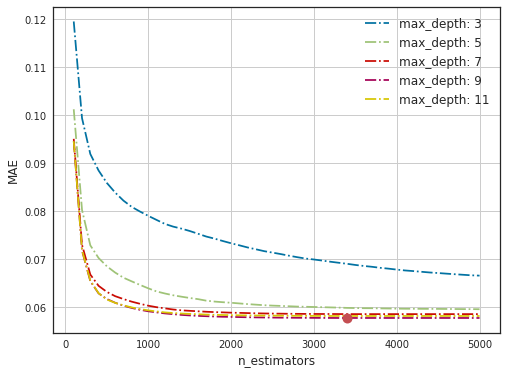

In [387]:
n_estimators = range(100,5001,100)
max_depth = [3,5,7,9,11]
plot_grid_search(gsearch_s2, n_estimators, max_depth, 'n_estimators', 'max_depth')
plt.savefig("gsearch_s2.png")

## shap

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_clean_z_score)

In [ ]:
explainer_waterfall = shap.Explainer(model, x_clean_z_score)
shap_values_waterfall = explainer_waterfall(x_clean_z_score,check_additivity=False)

100%|===================| 1699/1706 [02:51<00:00]        

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_clean_z_score.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, x_clean_z_score)

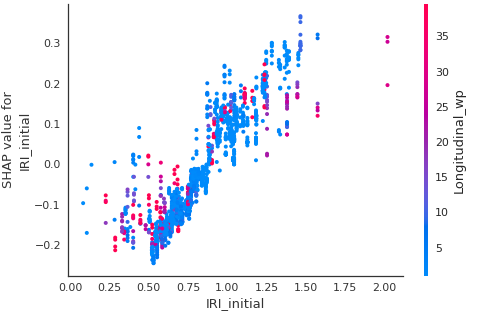

In [ ]:
shap.dependence_plot("IRI_initial", shap_values, x_clean_z_score)

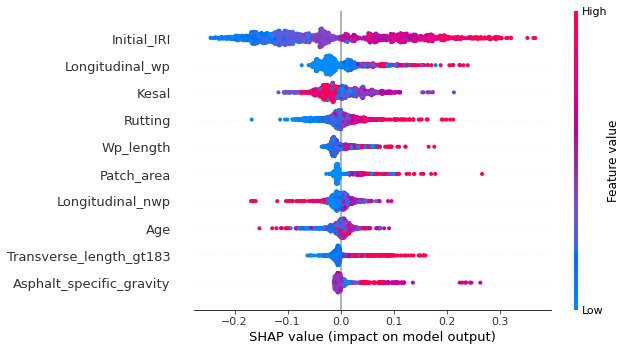

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_clean_z_score,max_display=10)

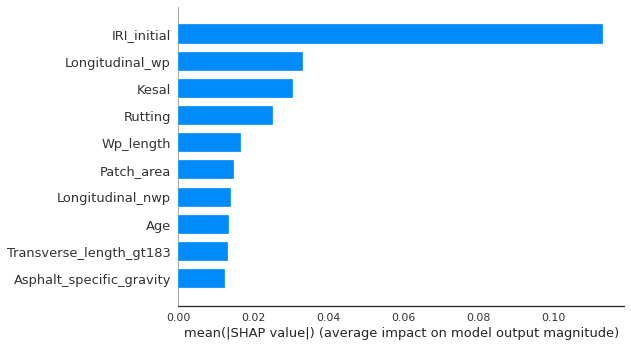

In [ ]:
shap.summary_plot(shap_values, x_clean_z_score, plot_type="bar",max_display=10)